In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Imports

In [2]:
import pandas as pd
import string
import numpy as np
import math
from collections import Counter
import re
import gc
import time
import scipy.spatial.distance as euc
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from gensim.models import KeyedVectors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Global Variables

In [3]:
# Paths  (CHANGE THESE PATHS ACCORDING TO YOUR LOCATION IN GDRIVE)

train_path = '/content/gdrive/My Drive/ML_Assignment_1/train.csv'
test_path = '/content/gdrive/My Drive/ML_Assignment_1/test.csv'
stop_words_path = '/content/gdrive/My Drive/ML_Assignment_1/stop_words.txt'

In [4]:
# Preprocessing

train_df = None # final processed train data frame
test_df = None # final processed test data frame
stop_words = [] # list containing stop words from the txt file provided to us with assignment files

# Storing stop words from list provided with assignment files into a python list

readingStopWords = open(stop_words_path, 'r')
for word in readingStopWords:
  word = word.strip('\n')
  stop_words.append(word)

for i in range(5):
  print(stop_words[i])

i
i'm
me
my
myself


In [5]:
# Feature Extraction

vocabulary = [] # bag of words
frequency_train = [] # a list that will contain lists representing the frequency of each word in our tweet with respect to vocabulary for train data
frequency_test = [] # a list that will contain lists representing the frequency of each word in our tweet with respect to vocabulary for test data

In [6]:
# for part 1

training_samples = [] # 𝐷 = {(𝑥1, 𝑦1), (𝑥2, 𝑦2), …, (𝑥𝑛, 𝑦𝑛)} = [ [x1,x2,...,xn] ]
training_samples_labels = [] # contains labels of corresponding training samples
test_samples = [] # They are in the form: [(tweet, corresponding feature vector)...]
test_samples_labels = [] # contains labels of corresponding test samples
all_distances = None # contains distances of each test sample with 11680 train samples

In [7]:
# for part 2

X_train = [] # 𝐷 = [[feature 1], [feature 2], ..., [feature n]]
Y_train = [] # [y1, y2, ..., yn]

X_test = [] # feature vectors for test data
Y_test = [] # true labels of test data

# Preprocessing

In [8]:
# This function takes path of the csv file (train.csv and test.csv), signal stands for whether data is train data or test data
# final data frame with processed train or test data will be returned

def preprocess(df_path, signal):

  if signal == 'train':
    print('Reading train data')
    print('Done Reading')
    print('')
  elif signal == 'test':
    print('Reading test data')
    print('Done Reading')
    print('')
  
  df = pd.read_csv(df_path)
  print(df.head())
  print('')

  # Converting from object to string data type
  # It should be noted pandas stores pointer to string and hence final data type would be still be an object
  print('Converting to string data type')
  df["Tweet"] = df["Tweet"].astype(str)
  print(df.dtypes)
  print('')

  # Converting to lower case
  print('Converting To Lower Case')
  df['Tweet'] = df['Tweet'].str.lower()
  print(df.head())
  print('')

  # Removing twitter handles
  print('Removing Twitter Handles')
  df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('@[^\s]+', '', x))
  print('')

  # Removing URLs
  print('Removing URLs')
  df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r"http\S+", "", x))
  df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r"https\S+", "", x))
  print('')

  # Removing unwanted characters
  print('Removing Unwanted Characters')
  df['Tweet'] = df['Tweet'].str.replace('@',' ')
  print(df.head())
  print('')

  # Removing punctuations
  print('Removing Punctuations')
  punct = string.punctuation
  punct = punct.replace("#", "")
  df['Tweet'] = df['Tweet'].str.replace('[{}]'.format(punct), ' ')
  print(df.head())
  print('')

  # Removing leading and trailing white spaces (if any)
  print('Removing Trailing And Leading White Spaces')
  df['Tweet'] = df['Tweet'].str.strip()
  print('Done Removing Trailing White Spaces')
  print('')


  # Removing stop words
  print('Removing Stop Words')
  df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
  print(df.head())
  print('')

  print('Doing some further preprocessing operations')
  # Removing special characters
  df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
  # Removing multiple spaces
  df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))
  # Removing byte like characters
  df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'^b\s+', '', x))
  print('Operations Completed')
  print('')

  # Final processed train data
  if signal == 'train':
    print('Saving Final Pre-Processed Train Data')
  elif signal == 'test':
    print('Saving Final Pre-Processed Test Data')

  print('')
  print('PreProcessing Completed')

  return df

In [9]:
# Pre Processing train data
train_df = preprocess(train_path, 'train')

Reading train data
Done Reading

  Sentiment                                              Tweet
0   neutral  @united 877 from amsterdam to ewr, 02.27.2015,...
1  negative       @united IT-problems with the link? #3thparty
2  positive  @united -today the staff @ MSP took customer s...
3  negative  @AmericanAir but have been yet to receive assi...
4  negative  @SouthwestAir  you won't let me change my rese...

Converting to string data type
Sentiment    object
Tweet        object
dtype: object

Converting To Lower Case
  Sentiment                                              Tweet
0   neutral  @united 877 from amsterdam to ewr, 02.27.2015,...
1  negative       @united it-problems with the link? #3thparty
2  positive  @united -today the staff @ msp took customer s...
3  negative  @americanair but have been yet to receive assi...
4  negative  @southwestair  you won't let me change my rese...

Removing Twitter Handles

Removing URLs

Removing Unwanted Characters
  Sentiment                 

In [10]:
# Pre Processing test data
test_df = preprocess(test_path, 'test')

Reading test data
Done Reading

  Sentiment                                              Tweet
0   neutral  @VirginAmerica to jump into the Dallas-Austin ...
1  positive  @AmericanAir Chicago seen from seat 6A, AA 162...
2  negative    @united you need a bag bouncer. Get it together
3  negative  @JetBlue Hey Jetblue, you stranded an entire p...
4  negative  @USAirways Big fail on not having curbside bag...

Converting to string data type
Sentiment    object
Tweet        object
dtype: object

Converting To Lower Case
  Sentiment                                              Tweet
0   neutral  @virginamerica to jump into the dallas-austin ...
1  positive  @americanair chicago seen from seat 6a, aa 162...
2  negative    @united you need a bag bouncer. get it together
3  negative  @jetblue hey jetblue, you stranded an entire p...
4  negative  @usairways big fail on not having curbside bag...

Removing Twitter Handles

Removing URLs

Removing Unwanted Characters
  Sentiment                  

# Feature Extraction

In [11]:
# This function takes in processed train data frame and makes bag of words (vocabulary) from it 
# returns list of final vocabulary

def create_BoW(df):
  vocab = []
  for index, row in df.iterrows():
    current_text = row['Tweet']
    current_text = current_text.split()
    for word in current_text:
      if word not in vocab:
        vocab.append(word)

  print('Total vocabulary: ', len(vocab)) 
  print('')
  print('Some words from the vocabulary are:')
  print('')
  for i in range(10):
    print(vocab[i])

  return vocab

In [12]:
# Generating bag of words (vocabulary)
vocabulary = create_BoW(train_df)

Total vocabulary:  11497

Some words from the vocabulary are:

877
amsterdam
ewr
02
27
2015
737
300
problems
link


In [13]:
# This function takes in train or test data frame, vocabulary, and a signal for whether data frame is train or test
# Returns the frequency vector (features) of train or test data

def extract_features(df, vocab, signal):

  freq_train = [] # to store word occurances in train data of each tweet

  freq_test = [] # to store word occurances in test data of each tweet

  # Counting frequencies

  for index, row in df.iterrows():
    current_text = row['Tweet']
    current_text = current_text.split()
    vec = [] # this will contain the frequencies
    for v in vocab:
      vec.append(current_text.count(v))
    if signal == 'train':
      freq_train.append(vec)
    else:
      freq_test.append(vec)

  # Some print statements for visualization

  if signal == 'train':
    print('Total frequency vectors: ', len(freq_train))
    print('')
    print('Some frequency vectors are:')
    print('')
    print(vocab)
    for i in range(5):
      print(freq_train[i])
    return freq_train
    
  else:
    print('Total frequency vectors: ', len(freq_test))
    print('')
    print('Some frequency vectors are:')
    print('')
    print(vocab)
    for i in range(5):
      print(freq_test[i])
    return freq_test

In [14]:
# Extracting features from train data
frequency_train = extract_features(train_df, vocabulary, 'train')

Total frequency vectors:  11680

Some frequency vectors are:

['877', 'amsterdam', 'ewr', '02', '27', '2015', '737', '300', 'problems', 'link', '3thparty', 'today', 'staff', 'msp', 'took', 'customer', 'service', 'new', 'level', 'father', 'passed', 'away', 'last', 'night', 'amp', 'helped', 'get', 'home', 'thanks', 'yet', 'receive', 'assistance', 'one', 'agents', 'securing', 'connection', 'many', 'miss', 'work', 'tomorrow', 'let', 'change', 'reservation', 'online', 'wasting', 'time', 'look', 'cabin', 'crew', 'vacancies', 'please', 'update', 'going', 'happen', 'passengers', 'flt', 'ua14', 'cancelled', 'flightled', 'redeem', 'travel', 'voucher', 'flight', 'reach', 'agent', 'phone', 'hold', 'expires', '24', 'hours', 'originating', 'sfo', 'lax', 'good', 'perspective', 'safety', 'concern', 'expressed', 'point', 'arrived', 'airport', 'communicationiskey', 'welllllll', 'rt', 'fleet', 'fleek', 'upgrades', '3130', 'paid', '8', 'wifi', 'load', 'website', 'functionally', 'except', 'live', 'streamin

In [15]:
# Extracting features from test data
frequency_test = extract_features(test_df, vocabulary, 'test')

Total frequency vectors:  2921

Some frequency vectors are:

['877', 'amsterdam', 'ewr', '02', '27', '2015', '737', '300', 'problems', 'link', '3thparty', 'today', 'staff', 'msp', 'took', 'customer', 'service', 'new', 'level', 'father', 'passed', 'away', 'last', 'night', 'amp', 'helped', 'get', 'home', 'thanks', 'yet', 'receive', 'assistance', 'one', 'agents', 'securing', 'connection', 'many', 'miss', 'work', 'tomorrow', 'let', 'change', 'reservation', 'online', 'wasting', 'time', 'look', 'cabin', 'crew', 'vacancies', 'please', 'update', 'going', 'happen', 'passengers', 'flt', 'ua14', 'cancelled', 'flightled', 'redeem', 'travel', 'voucher', 'flight', 'reach', 'agent', 'phone', 'hold', 'expires', '24', 'hours', 'originating', 'sfo', 'lax', 'good', 'perspective', 'safety', 'concern', 'expressed', 'point', 'arrived', 'airport', 'communicationiskey', 'welllllll', 'rt', 'fleet', 'fleek', 'upgrades', '3130', 'paid', '8', 'wifi', 'load', 'website', 'functionally', 'except', 'live', 'streaming

# Part 1

In [16]:
# This function takes train or test data frame, signal whether data is train or test and creates samples from it and frequency vector
# Returns train samples and xtrain and ytrain OR test samples and xtest and ytest

def create_samples(df, signal, frequencies):
  
  test_samps = [] # They are in the form: [(tweet, corresponding feature vector)...]
  if signal == 'train':
    # Creating training samples D in the following format: 𝐷 = {(𝑥1, 𝑦1), (𝑥2, 𝑦2), …, (𝑥𝑛, 𝑦𝑛)}

    train_samps = [] # D
    train_samps_lab = [] # labels of D
    xt = [] # X_train -> see global variables section for format
    yt = [] # Y_train -> see global variables section for format
    counter = 0
    for index, row in df.iterrows():
        label = row['Sentiment'] # value of y
        feature_sample = frequencies[counter] # value of x
        train_samps.append(feature_sample)
        train_samps_lab.append(label)

        # myTuple = (feature_sample, label) # (x, y) i.e. tuple of feature vector and corresponding label
        # train_samps.append(myTuple) # This is actually our 'D'

        xt.append(feature_sample) # FOR USE IN PART 2
        yt.append(label) # FOR USE IN PART 2
        counter = counter + 1
    # printing 1 training sample
    print('Training Sample')
    print(train_samps[0])
    print('Training Sample Label')
    print(train_samps_lab[0])
    return train_samps,train_samps_lab , xt, yt

  else:
    # Creating tuples of tweets in test data and their frequency vectors

    test_samps = [] # list containing feature vectors from test data
    test_samps_lab = [] # list containing true labels of test samples
    xt = [] # X_test -> see global variables section for format
    yt = [] # Y_test -> see global variables section for format
    counter = 0
    for index, row in df.iterrows():
        current_text = row['Tweet'] # tweet from test sample
        true_label = row['Sentiment'] # true label of the tweet
        feature_sample = frequencies[counter] # feature vector of the test sample tweet corresponding to BoW

        test_samps.append(feature_sample)
        test_samps_lab.append(true_label)


        # myTuple = (current_text, feature_sample, true_label) # (x, y, z) i.e. tuple of test tweet and corresponding feature vector and true label
        # test_samps.append(myTuple) # Appending to test samples


        xt.append(feature_sample) # FOR USE IN PART 2
        yt.append(true_label) # FOR USE IN PART 2
        counter = counter + 1
    # printing 1 test sample
    print('Test Sample')
    print(test_samps[0])
    print('Test Sample Label')
    print(test_samps_lab[0])
    return test_samps, test_samps_lab, xt, yt

In [17]:
# Generating Training Samples
training_samples, training_samples_labels, X_train, Y_train = create_samples(train_df, 'train', frequency_train)

Training Sample
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
# Generating Testing Samples
test_samples, test_samples_labels, X_test, Y_test = create_samples(test_df, 'test', frequency_test)

Test Sample
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
# Calculating all distances across all samples

start_time = time.time()
all_distances = euc.cdist(test_samples, training_samples, 'euclidean')
end_time = time.time()
print('total time taken: ', end_time - start_time)
all_distances = all_distances.tolist()

total time taken:  383.85991525650024


In [20]:

# Utility function to find maximum between two values
def max_of_two(n1, n2):
    if n1 > n2:
        return n1
    return n2

# Utility function to find maximum between three values
def max_of_three(n1, n2, n3):
    return max_of_two(n1, max_of_two(n2, n3))

In [21]:
# D : training samples in the form [[feature_vector_1],...[feature_vector_n]]
# train_labels : corresponding labels of feature vectors of training data
# k : value of k i.e 1, 3, 5, 7, 10, etc
# distance_vector : list of lists cotaining distances of test sample with every sample in training data

# returns the predicted label

def knn(D, train_labels, k, distance_vector):
  k = int(k)

  while (True):
    copy = np.array(distance_vector) # converting from list to numpy array
    labels_nearest = [] # 'k' nearest classes from test point
    copy = copy.argsort()[:k] # getting indexes of k smallest distances

    # Extracting corresponding labels from D
    for idx in copy:
      labels_nearest.append(train_labels[idx])

    # counting frequency of 'k' nearest labels
    majority = Counter(labels_nearest)

    # 1 class
    if len(majority) == 1:
      return majority.most_common(1)[0][0]

    # 2 classes
    elif len(majority) == 2:
      checking = majority.most_common(2)
      firstFreq = checking[0][1]
      secondFreq = checking[1][1]
      if firstFreq == secondFreq:
        k = k - 1
      elif firstFreq > secondFreq:
        return checking[0][0]
      else:
        return checking[1][0]

    # 3 classes
    elif len(majority) == 3:
      checking = majority.most_common(3)
      firstFreq = checking[0][1]
      secondFreq = checking[1][1]
      thirdFreq = checking[2][1]
      if firstFreq == secondFreq == thirdFreq:
        k = k - 1
      elif firstFreq != secondFreq != thirdFreq:
        greatest = max_of_three(firstFreq, secondFreq, thirdFreq)
        if greatest == firstFreq:
          return checking[0][0]
        elif greatest == secondFreq:
          return checking[1][0]
        else:
          return checking[2][0]
      else:
        if firstFreq > secondFreq and firstFreq > thirdFreq:
          return checking[0][0]
        elif secondFreq > firstFreq and secondFreq > thirdFreq:
          return checking[1][0]
        elif thirdFreq > secondFreq and thirdFreq > firstFreq:
          return checking[2][0]
        elif firstFreq < secondFreq and firstFreq < thirdFreq:
          k = k - 1
        elif secondFreq < firstFreq and secondFreq < thirdFreq:
          k = k - 1
        elif thirdFreq < secondFreq and thirdFreq < firstFreq:
          k = k - 1

In [22]:
K = [1, 3, 5, 7, 10]

# Classification accuracies for all values of k
accuracies = []

# macro-averages
precisions = []
recalls = []
f1_scores = []

# Counting total number of each class in test set

total_positive = 0
total_neutral = 0
total_negative = 0

for labels in test_samples_labels:
  if labels == 'positive':
    total_positive = total_positive + 1
  elif labels == 'negative':
    total_negative = total_negative + 1
  elif labels == 'neutral':
    total_neutral = total_neutral + 1

In [23]:
def predict(k):

  # for recall : formula -> (correctly_predicted_class / total_of_that_class_in_dataset)

  pos_correct = 0
  neg_correct = 0
  neut_correct = 0

  # For precision : formula -> (correctly_predicted_class / total_of_that_class_predicted)

  all_pred_pos = 0
  all_pred_neg = 0
  all_pred_neut = 0


  # ------------ Data for confusion matrix
  pp = 0
  pne = 0
  pneu = 0
  nep = 0
  nene = 0
  neneu = 0
  neup = 0
  neune = 0
  neuneu = 0


  # now predicting

  total_correct = 0
  print('Predicting for k = ', k)
  for i in range(len(test_samples)):
    ans = knn(training_samples, training_samples_labels, k, all_distances[i])
    # print('Predicted Label: ', ans, ' ', 'True Label: ', test_samples_labels[i])

    # classification accuracy
    if ans == test_samples_labels[i]:
      total_correct = total_correct + 1

    # for recall
    if ans == 'positive' and test_samples_labels[i] == 'positive':
      pos_correct = pos_correct + 1
    elif ans == 'neutral' and test_samples_labels[i] == 'neutral':
      neut_correct = neut_correct + 1
    elif ans == 'negative' and test_samples_labels[i] == 'negative':
      neg_correct = neg_correct + 1

    # for precision
    if ans == 'positive':
      all_pred_pos = all_pred_pos + 1
    elif ans == 'neutral':
      all_pred_neut = all_pred_neut + 1
    elif ans == 'negative':
      all_pred_neg = all_pred_neg + 1

    # for confusion matrix
    if ans == 'positive' and test_samples_labels[i] == 'positive':
      pp = pp + 1
    elif ans == 'positive' and test_samples_labels[i] == 'negative':
      pne = pne + 1
    elif ans == 'positive' and test_samples_labels[i] == 'neutral':
      pneu = pneu + 1

    elif ans == 'negative' and test_samples_labels[i] == 'positive':
      nep = nep + 1
    elif ans == 'negative' and test_samples_labels[i] == 'negative':
      nene = nene + 1
    elif ans == 'negative' and test_samples_labels[i] == 'neutral':
      neneu = neneu + 1

    elif ans == 'neutral' and test_samples_labels[i] == 'positive':
      neup = neup + 1
    elif ans == 'neutral' and test_samples_labels[i] == 'negative':
      neune = neune + 1
    elif ans == 'neutral' and test_samples_labels[i] == 'neutral':
      neuneu = neuneu + 1
      

  # for accuracy
  acc = total_correct / (len(test_samples))
  acc = acc * 100
  acc = "{:.2f}".format(acc)
  print("Classification Accuracy: ", acc, '%')
  accuracies.append(acc)

  # for recall
  recall_pos = (pos_correct / total_positive) * 100
  recall_neg = (neg_correct / total_negative) * 100
  recall_neut = (neut_correct / total_neutral) * 100
  total_recall = recall_pos + recall_neg + recall_neut
  total_recall = total_recall / 3
  total_recall = "{:.2f}".format(total_recall)
  print("Macro Recall: ", total_recall, '%')
  recalls.append(total_recall)

  # for precision
  pre_pos = (pos_correct / all_pred_pos) * 100
  pre_neg = (neg_correct / all_pred_neg) * 100
  pre_neut = (neut_correct / all_pred_neut) * 100
  total_precision = pre_pos + pre_neg + pre_neut
  total_precision = total_precision / 3
  total_precision = "{:.2f}".format(total_precision)
  print("Macro Precision: ", total_precision, '%')
  precisions.append(total_precision)

  # for F1
  f1pos = 2 * (pre_pos * recall_pos) / (pre_pos + recall_pos)
  f1neg = 2 * (pre_neg * recall_neg) / (pre_neg + recall_neg)
  f1neut = 2 * (pre_neut * recall_neut) / (pre_neut + recall_neut)
  macrof1 = (f1pos + f1neg + f1neut) / 3 
  macrof1 = "{:.2f}".format(macrof1)
  print("Macro F1 Score: ", macrof1, '%')
  f1_scores.append(macrof1)

  # for confusion matrix
  print('Confusion Matrix')
  cm = PrettyTable()
  cm.field_names = ["-", "positive", "negative", "neutral"]
  cm.add_row(["positive", pp, pne, pneu])
  cm.add_row(["negative", nep, nene, neneu])
  cm.add_row(["neutral", neup, neune, neuneu])
  print(cm)
  print('')

In [24]:
predict(1)
predict(3)
predict(5)
predict(7)
predict(10)

Predicting for k =  1
Classification Accuracy:  54.23 %
Macro Recall:  55.86 %
Macro Precision:  54.36 %
Macro F1 Score:  52.19 %
Confusion Matrix
+----------+----------+----------+---------+
|    -     | positive | negative | neutral |
+----------+----------+----------+---------+
| positive |   253    |   161    |    75   |
| negative |    66    |   948    |   157   |
| neutral  |   153    |   725    |   383   |
+----------+----------+----------+---------+

Predicting for k =  3
Classification Accuracy:  53.06 %
Macro Recall:  57.19 %
Macro Precision:  55.82 %
Macro F1 Score:  52.29 %
Confusion Matrix
+----------+----------+----------+---------+
|    -     | positive | negative | neutral |
+----------+----------+----------+---------+
| positive |   260    |   146    |    79   |
| negative |    63    |   863    |   109   |
| neutral  |   149    |   825    |   427   |
+----------+----------+----------+---------+

Predicting for k =  5
Classification Accuracy:  52.58 %
Macro Recall:  58.

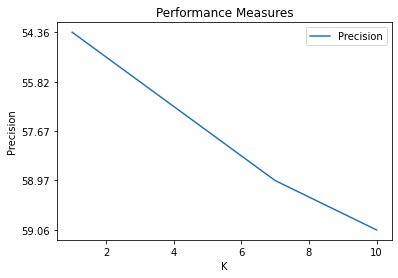

In [25]:
# Plotting

plt.gca().invert_yaxis()

x1 = K
y1 = precisions
plt.plot(x1, y1, label = "Precision")
plt.xlabel('K')
plt.ylabel('Precision')
plt.title('Performance Measures')
plt.legend()
plt.show()

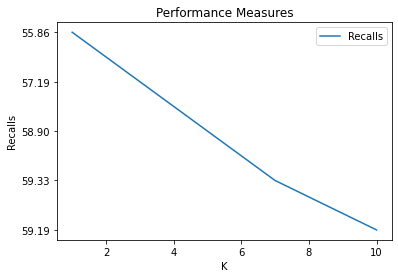

In [26]:
plt.gca().invert_yaxis()
x1 = K
y1 = recalls
plt.plot(x1, y1, label = "Recalls")
plt.xlabel('K')
plt.ylabel('Recalls')
plt.title('Performance Measures')
plt.legend()
plt.show()

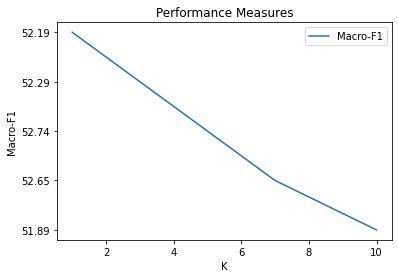

In [27]:
plt.gca().invert_yaxis()
x1 = K
y1 = f1_scores
plt.plot(x1, y1, label = "Macro-F1")
plt.xlabel('K')
plt.ylabel('Macro-F1')
plt.title('Performance Measures')
plt.legend()
plt.show()

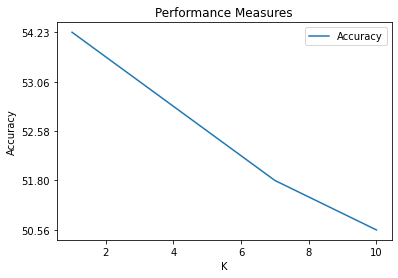

In [28]:
plt.gca().invert_yaxis()
x1 = K
y1 = accuracies
plt.plot(x1, y1, label = "Accuracy")
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Performance Measures')
plt.legend()
plt.show()

# Part 2

In [29]:
# Some variables

K = [1, 3, 5, 7, 10]
accuracies = []
c_reports = [] # classification reports
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [30]:
def sklearn_KNN_model(k):
  print('Predicting for k = ', k)

  classifier = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
  classifier.fit(X_train, Y_train)

  predictions = classifier.predict(X_test)
  
  # Calculating accuracy score
  acc = accuracy_score(Y_test, predictions)
  acc = acc * 100
  acc = "{:.2f}".format(acc)
  print('Accuracy Score: ', acc, '%')
  accuracies.append(acc)

  # Calculating classification report
  print('Classification Report')
  target_names = ['negative', 'neutral', 'positive']
  classification_rep = classification_report(Y_test, predictions, target_names=target_names)
  print(classification_rep)
  classification_rep = classification_report(Y_test, predictions, target_names=target_names, output_dict=True)
  c_reports.append(classification_rep)

  # Confusion Matrix
  print('Confusion Matrix')
  conf_mat = confusion_matrix(Y_test, predictions, labels=['negative', 'neutral', 'positive'])
  print(conf_mat)

In [31]:
sklearn_KNN_model(1)

Predicting for k =  1
Accuracy Score:  54.40 %
Classification Report
              precision    recall  f1-score   support

    negative       0.84      0.49      0.62      1834
     neutral       0.32      0.70      0.44       615
    positive       0.52      0.55      0.54       472

    accuracy                           0.54      2921
   macro avg       0.56      0.58      0.53      2921
weighted avg       0.68      0.54      0.57      2921

Confusion Matrix
[[897 772 165]
 [109 431  75]
 [ 67 144 261]]


In [32]:
sklearn_KNN_model(3)

Predicting for k =  3
Accuracy Score:  54.95 %
Classification Report
              precision    recall  f1-score   support

    negative       0.80      0.51      0.62      1834
     neutral       0.31      0.68      0.43       615
    positive       0.61      0.54      0.57       472

    accuracy                           0.55      2921
   macro avg       0.57      0.58      0.54      2921
weighted avg       0.67      0.55      0.57      2921

Confusion Matrix
[[933 794 107]
 [143 417  55]
 [ 89 128 255]]


In [33]:
sklearn_KNN_model(5)

Predicting for k =  5
Accuracy Score:  53.78 %
Classification Report
              precision    recall  f1-score   support

    negative       0.85      0.47      0.61      1834
     neutral       0.31      0.75      0.44       615
    positive       0.61      0.53      0.56       472

    accuracy                           0.54      2921
   macro avg       0.59      0.58      0.53      2921
weighted avg       0.69      0.54      0.56      2921

Confusion Matrix
[[864 867 103]
 [ 98 459  58]
 [ 60 164 248]]


In [34]:
sklearn_KNN_model(7)

Predicting for k =  7
Accuracy Score:  53.41 %
Classification Report
              precision    recall  f1-score   support

    negative       0.87      0.44      0.59      1834
     neutral       0.31      0.79      0.45       615
    positive       0.60      0.56      0.58       472

    accuracy                           0.53      2921
   macro avg       0.60      0.60      0.54      2921
weighted avg       0.71      0.53      0.56      2921

Confusion Matrix
[[810 909 115]
 [ 71 487  57]
 [ 46 163 263]]


In [35]:
sklearn_KNN_model(10)

Predicting for k =  10
Accuracy Score:  52.65 %
Classification Report
              precision    recall  f1-score   support

    negative       0.88      0.43      0.58      1834
     neutral       0.31      0.80      0.45       615
    positive       0.59      0.54      0.57       472

    accuracy                           0.53      2921
   macro avg       0.59      0.59      0.53      2921
weighted avg       0.71      0.53      0.55      2921

Confusion Matrix
[[790 931 113]
 [ 62 491  62]
 [ 49 166 257]]


In [36]:
# extracting macro averages from classfication reports

precisions = []
recalls = []
f1 = []

for reports in c_reports:
  precisions.append(reports['macro avg']['precision'])
  recalls.append(reports['macro avg']['recall'])
  f1.append(reports['macro avg']['f1-score'])

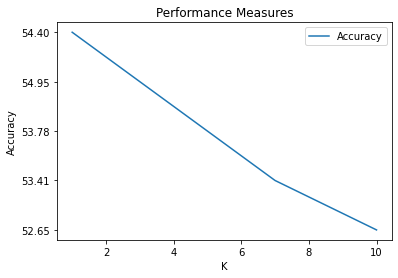

In [37]:
plt.gca().invert_yaxis()
x1 = K
y1 = accuracies
plt.plot(x1, y1, label = "Accuracy")
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Performance Measures')
plt.legend()
plt.show()

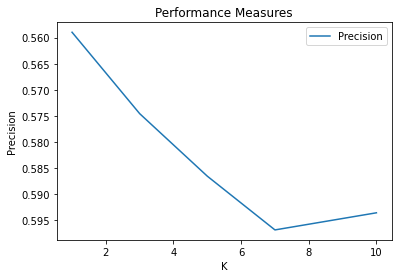

In [38]:
plt.gca().invert_yaxis()
x1 = K
y1 = precisions
plt.plot(x1, y1, label = "Precision")
plt.xlabel('K')
plt.ylabel('Precision')
plt.title('Performance Measures')
plt.legend()
plt.show()

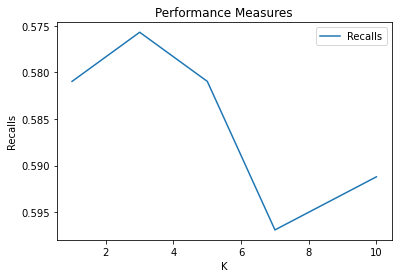

In [39]:
plt.gca().invert_yaxis()
x1 = K
y1 = recalls
plt.plot(x1, y1, label = "Recalls")
plt.xlabel('K')
plt.ylabel('Recalls')
plt.title('Performance Measures')
plt.legend()
plt.show()

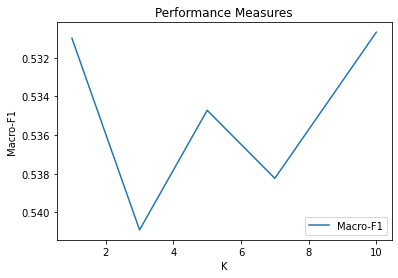

In [40]:
plt.gca().invert_yaxis()
x1 = K
y1 = f1
plt.plot(x1, y1, label = "Macro-F1")
plt.xlabel('K')
plt.ylabel('Macro-F1')
plt.title('Performance Measures')
plt.legend()
plt.show()

# Part 3

In [41]:
# downloading

!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2020-10-14 04:10:19--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.83.67
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.83.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  46.3MB/s    in 58s     

2020-10-14 04:11:17 (27.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [42]:
# loading pre-trained representations

word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [43]:
# feature getter

def getFeatures(text):
  lst = []
  text = text.split()
  for word in text:
    if word in word2vec.vocab:
      lst.append(word)
  if len(lst) > 0:
    return np.mean(word2vec[lst], axis=0)
  else:
    return None

In [44]:
# This function takes in train or test data frame, and a signal for whether data frame is train or test
# Returns the frequency vector (features) of train or test data

indexes_skipped_train = [] # list of indexes skipped in data frame because they were not in word2vec vocab
indexes_skipped_test = [] # list of indexes skipped in data frame because they were not in word2vec vocab

def extract_features_2(df, signal):

  freq_train = [] # to store word occurances in train data of each tweet

  freq_test = [] # to store word occurances in test data of each tweet

  for index, row in df.iterrows():
    current_text = row['Tweet']
    text_embedding = getFeatures(current_text)
    if text_embedding is None:
      if signal == 'train':
        indexes_skipped_train.append(index)
      else:
        indexes_skipped_test.append(index)
      continue
    else:
      if signal == 'train':
        freq_train.append(text_embedding.tolist())
      else:
        freq_test.append(text_embedding.tolist())

  if signal == 'train':
    print('Total embeddings vectors: ', len(freq_train))
    return freq_train
    
  else:
    print('Total embeddings vectors: ', len(freq_test))
    return freq_test

## Re-Running Part 1

In [45]:
# Extracting features from train data

frequency_train = extract_features_2(train_df, 'train')


Total embeddings vectors:  11668


In [46]:
# Extracting features from test data
frequency_test = extract_features_2(test_df, 'test')

Total embeddings vectors:  2918


In [47]:
print("Indexes skipped in train data: ", indexes_skipped_train)
print("Indexes skipped in test data: ", indexes_skipped_test)

# dropping skipped indexes

for idx in indexes_skipped_train:
  train_df = train_df.drop(train_df.index[[idx]])

train_df = train_df.reset_index()

for idx in indexes_skipped_test:
  test_df = test_df.drop(test_df.index[[idx]])

test_df = test_df.reset_index()

Indexes skipped in train data:  [280, 2896, 2897, 3805, 4074, 5021, 5569, 6089, 6817, 7540, 9045, 9406]
Indexes skipped in test data:  [500, 576, 1072]


In [48]:
# Generating Training Samples
training_samples, training_samples_labels, X_train, Y_train = create_samples(train_df, 'train', frequency_train)

Training Sample
[-0.07861328125, -0.08642578125, 0.06201171875, 0.3515625, -0.1552734375, -0.00701904296875, -0.130859375, -0.23046875, -0.06982421875, -0.0021820068359375, -0.0269775390625, 0.055419921875, -0.1083984375, -0.08984375, 0.150390625, -0.11181640625, 0.21875, 0.1630859375, 0.03466796875, -0.0419921875, -0.1826171875, -0.1181640625, 0.224609375, 0.0016937255859375, -0.1318359375, 0.1259765625, -0.0966796875, 0.306640625, 0.0279541015625, -0.0576171875, 0.04296875, -0.006561279296875, -0.030029296875, -0.169921875, -0.09033203125, -0.028564453125, -0.25, 0.07177734375, 0.054931640625, 0.01385498046875, -0.2216796875, 0.058349609375, 0.283203125, 0.12109375, 0.2275390625, -0.2392578125, 0.0830078125, -0.185546875, -0.205078125, 0.2060546875, 0.0015716552734375, 0.125, 0.2138671875, -0.07373046875, 0.0089111328125, -0.0634765625, -0.2734375, -0.048095703125, -0.11669921875, -0.0595703125, 0.052001953125, -0.197265625, -0.150390625, 0.001373291015625, 0.026123046875, -0.1855468

In [49]:
# Generating Testing Samples
test_samples, test_samples_labels, X_test, Y_test = create_samples(test_df, 'test', frequency_test)

Test Sample
[-0.11065673828125, -0.07073974609375, -0.060546875, 0.138916015625, 0.00782012939453125, -0.1426544189453125, -0.08013916015625, -0.0877685546875, 0.011474609375, 0.06414794921875, -0.2197265625, -0.15576171875, -0.120880126953125, -0.14410400390625, -0.067626953125, 0.07350540161132812, 0.03851318359375, 0.13128662109375, -0.0246734619140625, -0.15252685546875, -0.051971435546875, -0.0634765625, 0.04721832275390625, 0.01811981201171875, -0.2242431640625, 0.0923614501953125, -0.120697021484375, 0.19683837890625, -0.11767578125, -0.111328125, 0.0123291015625, 0.111083984375, -0.07208251953125, -0.2103424072265625, -0.1541748046875, 0.00797271728515625, -0.018096923828125, 0.062744140625, 0.2373046875, 0.05145263671875, 0.026214599609375, -0.1673583984375, 0.255859375, 0.1868896484375, -0.107421875, -0.02864837646484375, 0.09878158569335938, -0.04736328125, 0.03912353515625, 0.10848236083984375, 0.235107421875, 0.031036376953125, 0.0673828125, 0.156005859375, 0.0528717041015

In [50]:
# Calculating all distances across all samples

start_time = time.time()
all_distances = euc.cdist(test_samples, training_samples, 'euclidean')
end_time = time.time()
print('total time taken: ', end_time - start_time)
all_distances = all_distances.tolist()

total time taken:  8.267468690872192


In [51]:
K = [1, 3, 5, 7, 10]

# Classification accuracies for all values of k
accuracies = []

# macro-averages
precisions = []
recalls = []
f1_scores = []

# Counting total number of each class in test set

total_positive = 0
total_neutral = 0
total_negative = 0

for labels in test_samples_labels:
  if labels == 'positive':
    total_positive = total_positive + 1
  elif labels == 'negative':
    total_negative = total_negative + 1
  elif labels == 'neutral':
    total_neutral = total_neutral + 1

In [52]:
predict(1)
predict(3)
predict(5)
predict(7)
predict(10)

Predicting for k =  1
Classification Accuracy:  71.45 %
Macro Recall:  60.47 %
Macro Precision:  63.57 %
Macro F1 Score:  61.62 %
Confusion Matrix
+----------+----------+----------+---------+
|    -     | positive | negative | neutral |
+----------+----------+----------+---------+
| positive |   258    |   103    |    80   |
| negative |   151    |   1578   |   286   |
| neutral  |    62    |   151    |   249   |
+----------+----------+----------+---------+

Predicting for k =  3
Classification Accuracy:  73.54 %
Macro Recall:  60.22 %
Macro Precision:  67.89 %
Macro F1 Score:  62.49 %
Confusion Matrix
+----------+----------+----------+---------+
|    -     | positive | negative | neutral |
+----------+----------+----------+---------+
| positive |   261    |    57    |    66   |
| negative |   162    |   1678   |   342   |
| neutral  |    48    |    97    |   207   |
+----------+----------+----------+---------+

Predicting for k =  5
Classification Accuracy:  74.30 %
Macro Recall:  58.

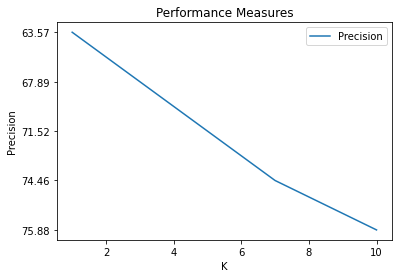

In [53]:
# Plotting

plt.gca().invert_yaxis()

x1 = K
y1 = precisions
plt.plot(x1, y1, label = "Precision")
plt.xlabel('K')
plt.ylabel('Precision')
plt.title('Performance Measures')
plt.legend()
plt.show()

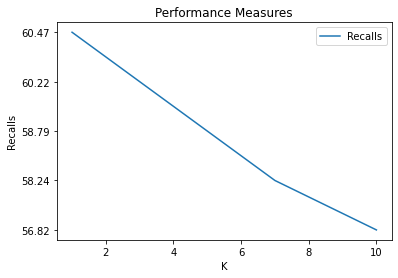

In [54]:
plt.gca().invert_yaxis()
x1 = K
y1 = recalls
plt.plot(x1, y1, label = "Recalls")
plt.xlabel('K')
plt.ylabel('Recalls')
plt.title('Performance Measures')
plt.legend()
plt.show()

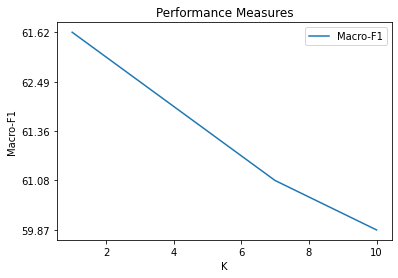

In [55]:
plt.gca().invert_yaxis()
x1 = K
y1 = f1_scores
plt.plot(x1, y1, label = "Macro-F1")
plt.xlabel('K')
plt.ylabel('Macro-F1')
plt.title('Performance Measures')
plt.legend()
plt.show()

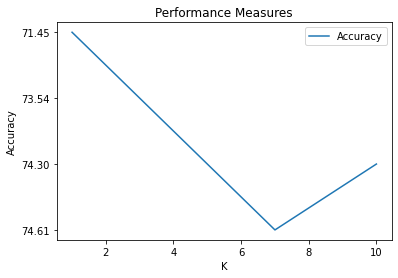

In [56]:
plt.gca().invert_yaxis()
x1 = K
y1 = accuracies
plt.plot(x1, y1, label = "Accuracy")
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Performance Measures')
plt.legend()
plt.show()

## Re-Running Part 2

In [57]:
# Some variables

K = [1, 3, 5, 7, 10]
accuracies = []
c_reports = [] # classification reports
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [58]:
sklearn_KNN_model(1)

Predicting for k =  1
Accuracy Score:  71.25 %
Classification Report
              precision    recall  f1-score   support

    negative       0.78      0.86      0.82      1832
     neutral       0.53      0.40      0.46       615
    positive       0.58      0.55      0.57       471

    accuracy                           0.71      2918
   macro avg       0.63      0.60      0.61      2918
weighted avg       0.70      0.71      0.70      2918

Confusion Matrix
[[1574  153  105]
 [ 288  245   82]
 [ 151   60  260]]


In [59]:
sklearn_KNN_model(3)

Predicting for k =  3
Accuracy Score:  73.41 %
Classification Report
              precision    recall  f1-score   support

    negative       0.75      0.93      0.83      1832
     neutral       0.62      0.30      0.40       615
    positive       0.72      0.53      0.61       471

    accuracy                           0.73      2918
   macro avg       0.70      0.59      0.61      2918
weighted avg       0.72      0.73      0.71      2918

Confusion Matrix
[[1709   81   42]
 [ 377  182   56]
 [ 189   31  251]]


In [60]:
sklearn_KNN_model(5)

Predicting for k =  5
Accuracy Score:  74.13 %
Classification Report
              precision    recall  f1-score   support

    negative       0.74      0.97      0.84      1832
     neutral       0.66      0.23      0.35       615
    positive       0.79      0.53      0.63       471

    accuracy                           0.74      2918
   macro avg       0.73      0.58      0.61      2918
weighted avg       0.73      0.74      0.70      2918

Confusion Matrix
[[1769   46   17]
 [ 420  144   51]
 [ 194   27  250]]


In [61]:
sklearn_KNN_model(7)

Predicting for k =  7
Accuracy Score:  74.43 %
Classification Report
              precision    recall  f1-score   support

    negative       0.74      0.98      0.84      1832
     neutral       0.75      0.22      0.35       615
    positive       0.79      0.52      0.63       471

    accuracy                           0.74      2918
   macro avg       0.76      0.57      0.60      2918
weighted avg       0.75      0.74      0.70      2918

Confusion Matrix
[[1790   26   16]
 [ 429  138   48]
 [ 208   19  244]]


In [62]:
sklearn_KNN_model(10)

Predicting for k =  10
Accuracy Score:  73.78 %
Classification Report
              precision    recall  f1-score   support

    negative       0.73      0.99      0.84      1832
     neutral       0.77      0.19      0.31       615
    positive       0.80      0.48      0.60       471

    accuracy                           0.74      2918
   macro avg       0.77      0.55      0.58      2918
weighted avg       0.75      0.74      0.69      2918

Confusion Matrix
[[1808   13   11]
 [ 451  119   45]
 [ 223   22  226]]


In [63]:
# extracting macro averages from classfication reports

precisions = []
recalls = []
f1 = []

for reports in c_reports:
  precisions.append(reports['macro avg']['precision'])
  recalls.append(reports['macro avg']['recall'])
  f1.append(reports['macro avg']['f1-score'])

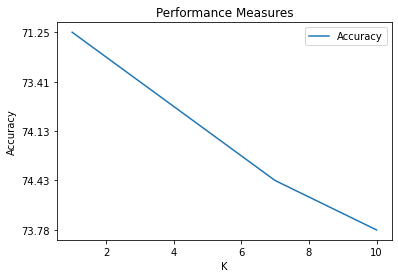

In [64]:
plt.gca().invert_yaxis()
x1 = K
y1 = accuracies
plt.plot(x1, y1, label = "Accuracy")
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Performance Measures')
plt.legend()
plt.show()

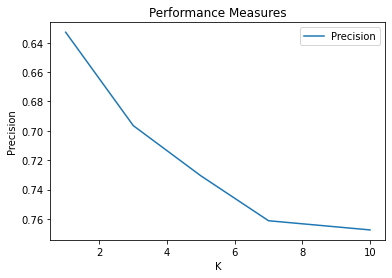

In [65]:
plt.gca().invert_yaxis()
x1 = K
y1 = precisions
plt.plot(x1, y1, label = "Precision")
plt.xlabel('K')
plt.ylabel('Precision')
plt.title('Performance Measures')
plt.legend()
plt.show()

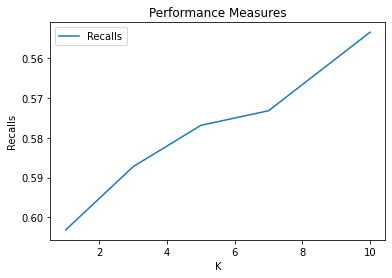

In [66]:
plt.gca().invert_yaxis()
x1 = K
y1 = recalls
plt.plot(x1, y1, label = "Recalls")
plt.xlabel('K')
plt.ylabel('Recalls')
plt.title('Performance Measures')
plt.legend()
plt.show()

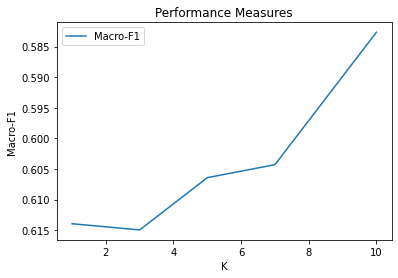

In [67]:
plt.gca().invert_yaxis()
x1 = K
y1 = f1
plt.plot(x1, y1, label = "Macro-F1")
plt.xlabel('K')
plt.ylabel('Macro-F1')
plt.title('Performance Measures')
plt.legend()
plt.show()

# THE END FINALLY !